### DM data science task

Dataset contains list of series of measurements of air pressure provided by Air Pump, where in some cases Pump failed and in some cases not. Goal is to build a predictive model that will predict whether Pump worked fine or not.  

##### Note: this is the second attempt that should improve the performance of the initial model, mainly by creation of clever features that are used in the model

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

DATA_PATH = r'C:\Users\pacak\Downloads\data\data.parquet'
LABELS_PATH = r'C:\Users\pacak\Downloads\data\labels.csv'

import numpy as np

np.random.seed(42)

import seaborn as sns
from sklearn.metrics import roc_auc_score

from datamole_airpressure.common.metrics import Metrics, individual_auc
from datamole_airpressure.common.plots import show_series, visualise_feature
from datamole_airpressure.tabular.feature_extraction import FeatureExtractor
from datamole_airpressure.tabular.feature_extraction_config import \
    feature_config
from datamole_airpressure.tabular.lgbm_model import LGBMModel
from datamole_airpressure.tabular.lgbm_model_config import params as config

In [3]:
data =  pd.read_parquet(DATA_PATH, engine='pyarrow')
labels = pd.read_csv(LABELS_PATH)

# Target distribution

False    0.874858
True     0.107431
NaN      0.017710
Name: PumpFailed, dtype: float64

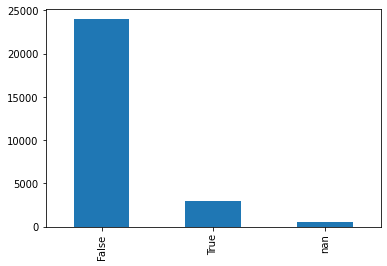

In [4]:
labels['PumpFailed'].value_counts(dropna = False).plot(kind='bar')
labels['PumpFailed'].value_counts(dropna = False)/len(labels)

There are some measurements where is unknownow whether Pump failed or not, therefore we wil drop these measurements 

In [5]:
labels = labels[labels['PumpFailed'].notnull()].reset_index(drop = True)

In [6]:
labels.head()

,MachineId,MeasurementId,PumpFailed,SlowStart,SlowEnd
0,0_0_0,0,False,False,False
1,0_0_2,0,False,False,False
2,0_0_3,0,True,False,False
3,0_1_1,1,True,False,False
4,1_0_0,2,False,True,False


### Train/ Test split of the labels
With the ration 70% od data to train and 30% of data to test.

In [7]:
labels['random'] = np.random.random(size=len(labels))
labels_train = labels[labels['random']<=0.7].reset_index(drop = True)
labels_test = labels[labels['random']>0.7].reset_index(drop =True)

In [8]:
labels.head()

,MachineId,MeasurementId,PumpFailed,SlowStart,SlowEnd,random
0,0_0_0,0,False,False,False,0.374540
1,0_0_2,0,False,False,False,0.950714
2,0_0_3,0,True,False,False,0.731994
3,0_1_1,1,True,False,False,0.598658
4,1_0_0,2,False,True,False,0.156019


### Plot few measurements with Pupfailed = True

machine_id: 6_0_0, measurement_id:32
No observatons:
(391,)
   MachineId  MeasurementId PumpFailed SlowStart SlowEnd    random
74     6_0_0             32       True       NaN     NaN  0.706857


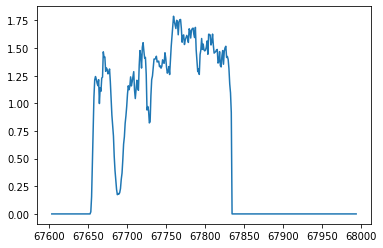

In [114]:
show_series(data, labels, '6_0_0', 32)

machine_id: 6_0_0, measurement_id:29
No observatons:
(335,)
   MachineId  MeasurementId PumpFailed SlowStart SlowEnd    random
70     6_0_0             29       True       NaN     NaN  0.772245


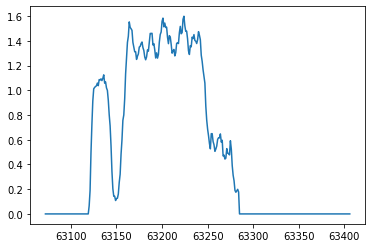

In [113]:
show_series(data, labels, '6_0_0', 29)

machine_id: 6_0_3, measurement_id:28
No observatons:
(396,)
   MachineId  MeasurementId PumpFailed SlowStart SlowEnd    random
69     6_0_3             28       True       NaN     NaN  0.986887


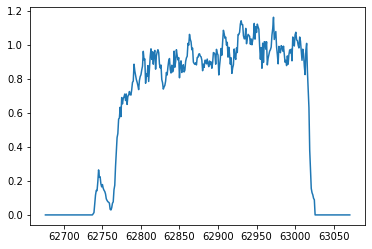

In [112]:
show_series(data, labels, '6_0_3', 28)

### Plot 3 measurements with Pupfailed = False

machine_id: 0_0_0, measurement_id:0
No observatons:
(368,)
  MachineId  MeasurementId PumpFailed SlowStart SlowEnd   random
0     0_0_0              0      False     False   False  0.37454


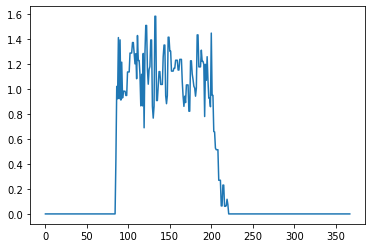

In [116]:
show_series(data, labels, '0_0_0', 0)

machine_id: 10_0_2, measurement_id:8833
No observatons:
(371,)
      MachineId  MeasurementId PumpFailed SlowStart SlowEnd  random
26895    10_0_2           8833      False     False   False  0.0778


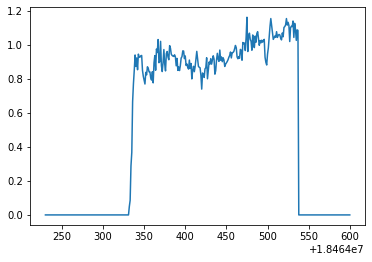

In [117]:
show_series(data, labels, '10_0_2', 8833 )

machine_id: 10_0_3, measurement_id:8834
No observatons:
(348,)
      MachineId  MeasurementId PumpFailed SlowStart SlowEnd    random
26899    10_0_3           8834      False     False   False  0.227612


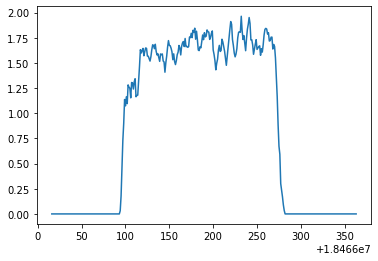

In [119]:
show_series(data, labels, '10_0_3', 8834 )

It looks that measurements with Pumpfailed = True has drop of pressure in the beginning

#### Distribution of counts of individual data points within different  MeasurementIds

Average number of measurements is 490.52167286245356
Median number of measurements is 436.0


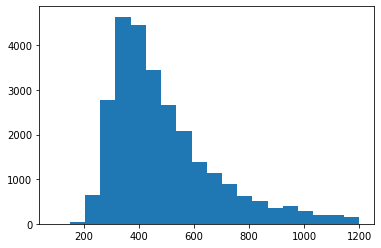

In [13]:
# Measurementsid -1 corresponds to thhe data without labels 
pressure_counts = data[data['MeasurementId']!=-1].groupby(['MachineId', 'MeasurementId']).count()['Pressure'].values
plt.hist(pressure_counts, bins = 20 )
print(f'Average number of measurements is {np.mean(pressure_counts)}')
print(f'Median number of measurements is {np.median(pressure_counts)}')

Usually there is about 490 data points in one Measurements 

## Extraction of statistical featues from measurements
For the purpose of building of ML model, that will predict whether Pump failed or not, based on the measurement values, first it is necessary to extract several statistical features from measurements.

# Changes from previous version:

In the new version of notebook, the biggest change is that the statistical features are not extracted bot only from the entire measurements, but also from its parts, for example from the first half. The reson for this is that it was observed that pumpfail pattern (dropof the pressure) usually happens in the beginning.

Second change was that as the preprocessing, completely all of the features are preprocessed with filtering out only the measurements with values greater than 0, which means that we don't care about time before and after the pump was on.

Now there are 4 types of features:
#### With suffix '_non_zero_percentile' 
 - standard feature from only percentile-relevant part of the data
 - For example feature_mean_non_zero_0.25 means mean of the non-zero measurement from first quarter of the data
 - Note: If the percentile is greatre than 0.5, the it is taken from the end of the data. So for example
         feature_mean_non_zero_0.8 denotes average from last 80% of the data

#### With suffix '_lagged_percentile' 
 - Means feature that is done on top of the series that is created as first order differences from raw measuments.
 - meaning of the percentile is the same as in previous version

#### With suffix '_lagged_abs_percentile'
 - Same as previous, but the series of differences is converted to absolute values

#### With suffix '_percentile_ratio'
 - These features means ratio between statistic created from percentile relevant first part of the data vs rest of the data
 - For example feature_mean_non_zero_0.25_ratio means ratio of averages, where nominator as created from the first 25% of the      data and denominator is created from last 75% of the data




In [91]:
# print imported config
feature_config

{'features_to_calculate': {'feature_mean_non_zero': True,
  'feature_variance_non_zero': True,
  'feature_median_non_zero': True,
  'feature_max_non_zero': True,
  'feature_min_non_zero': False,
  'feature_kurtosis_non_zero': True,
  'feature_skew_non_zero': True,
  'feature_max_min_diff_non_zero': True,
  'feature_sum_non_zero': True,
  'feature_mean_lagged': True,
  'feature_variance_lagged': True,
  'feature_median_lagged': True,
  'feature_max_lagged': True,
  'feature_min_lagged': False,
  'feature_kurtosis_lagged': True,
  'feature_skew_lagged': True,
  'feature_max_min_diff_lagged': True,
  'feature_sum_lagged': True,
  'feature_mean_lagged_abs': True,
  'feature_variance_lagged_abs': True,
  'feature_median_lagged_abs': True,
  'feature_min_lagged_abs': False,
  'feature_kurtosis_lagged_abs': True,
  'feature_skew_lagged_abs': True,
  'feature_max_min_diff_lagged_abs': True,
  'feature_sum_lagged_abs': True},
 'percentiles_data_to_calculate': [0.05, 0.1, 0.2, 0.25, 0.3, 0.49, 1

In [ ]:
feature_extractor = FeatureExtractor(feature_config)
data_features = feature_extractor.run(data)

In [ ]:
# Bit of data preprocessing, I did not to create any special function for that

# Merge features to train and test data
train_data = pd.merge(labels_train, data_features, how = 'inner', left_on = ['MachineId', 'MeasurementId'],
                             right_on = ['MachineId', 'MeasurementId'])
test_data = pd.merge(labels_test, data_features, how = 'inner', left_on = ['MachineId', 'MeasurementId'],
                             right_on = ['MachineId', 'MeasurementId'])

train_target = train_data['PumpFailed'].astype('int')
test_target = test_data['PumpFailed'].astype('int')

preds = list(data_features)[2:]
for col in preds:
    train_data[col] = train_data[col].astype('float')
    test_data[col] = test_data[col].astype('float')  

### EDA - Individual sorting power of the predictors

Visualise and print individual sorting power of the created features.

Note: For individual AUC holds assumption is that the relationship between target and feature is linear.

In [126]:
preds = list(data_features)[2:]
individual_aucs = []
for col in preds:
    individual_aucs.append(individual_auc(train_data, col, 'PumpFailed'))

In [130]:
individual_features_overview = pd.DataFrame.from_dict({'feature': preds, 'auc': individual_aucs})
individual_features_overview.sort_values(by = 'auc', ascending = False)

,feature,auc
188,feature_kurtosis_non_zero_0.3,0.789619
142,feature_kurtosis_non_zero_0.25,0.783355
97,feature_skew_non_zero_0.2,0.766421
96,feature_kurtosis_non_zero_0.2,0.764344
234,feature_kurtosis_non_zero_0.49,0.761210
143,feature_skew_non_zero_0.25,0.756458
94,feature_median_non_zero_0.2,0.749175
92,feature_mean_non_zero_0.2,0.744002
189,feature_skew_non_zero_0.3,0.735910
138,feature_mean_non_zero_0.25,0.731594


#### Plot distribution charts for some seleced features

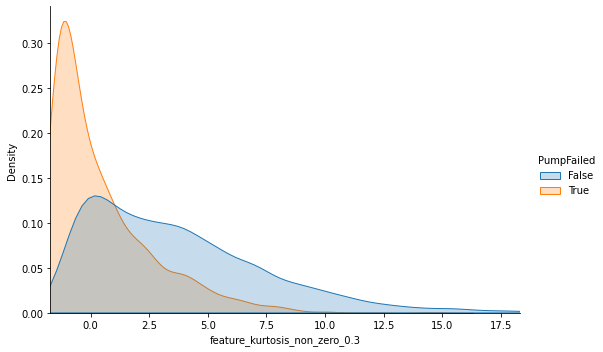

0.7896192599790066


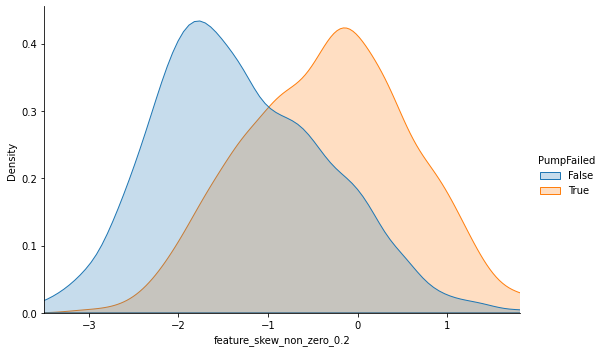

0.7664212276332765


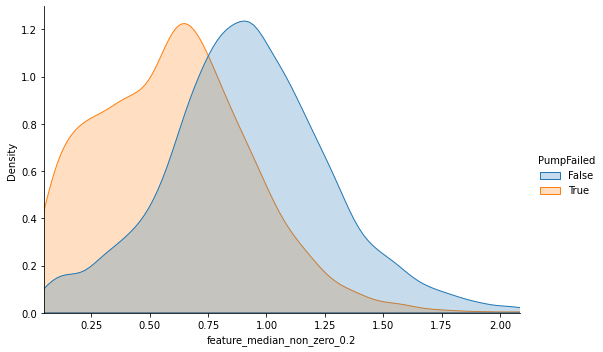

0.749174735757332


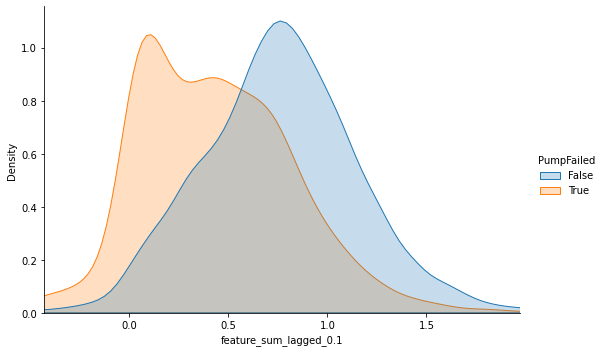

0.7262228492864297


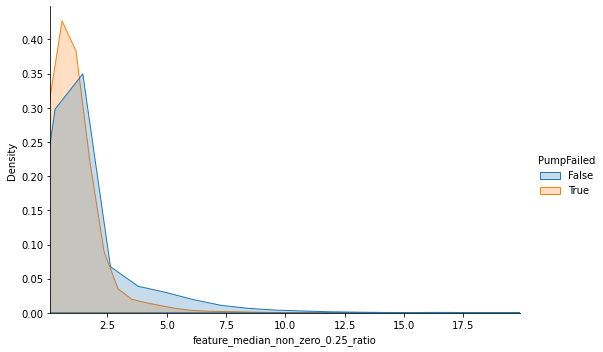

0.7254825873341293


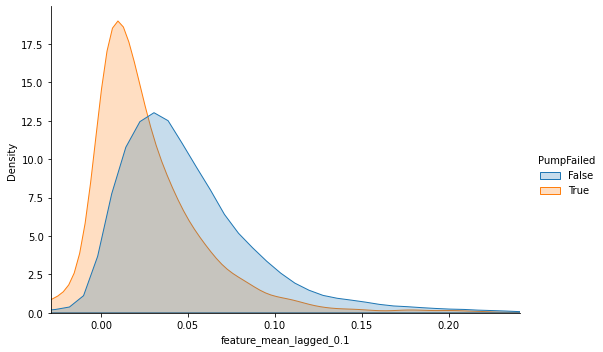

0.7012925445846074


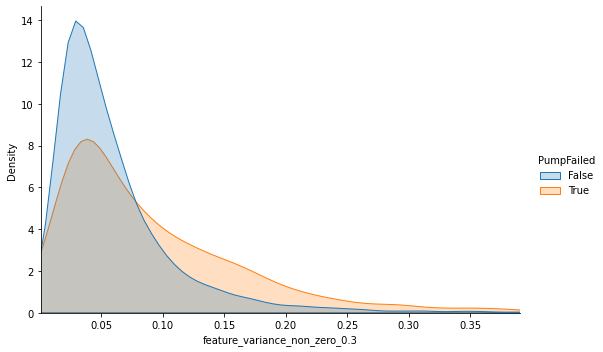

0.6301927514429008


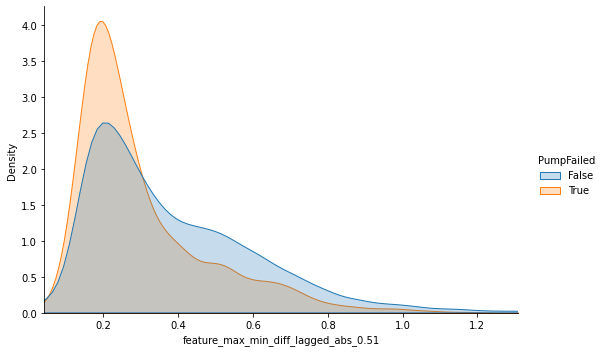

0.6165314086413907


In [145]:
cols_to_explore_with_eda = ['feature_kurtosis_non_zero_0.3', 'feature_skew_non_zero_0.2', 'feature_median_non_zero_0.2', 
                           'feature_sum_lagged_0.1', 'feature_median_non_zero_0.25_ratio', 'feature_mean_lagged_0.1',
                           'feature_variance_non_zero_0.3', 'feature_max_min_diff_lagged_abs_0.51']

for col in cols_to_explore_with_eda:
    visualise_feature(train_data, col, 'PumpFailed')

It is visible that those features has some distrimination power. Lets blend all of them into Machine learning model.

### ML model - LGBM

Predictive model - LGBM
LGBM is newer implementation of famous XGBoost algorithm. Trained model is ensemble of many decision trees (usually), where every next decision tree is trained with (pseudo)residuals as a target variable from previous decion trees. Final prediction is then made as average of these decision trees.

LGBM implementation has few advantages over XGBoost - it can handle categorical variables implicitly (you do not need OHE), training of the model is much faster, etc. The results are usually pretty similar.

Fitting of decision trees requires less data preparation than for example logistic regression, where linear relationship between target and variables is demanded. For example I do not have to care about quadratic relationship between age and target, because decision trees can handle it pretty fine. Therefore I do not need to care much about data preprocessing right now (i am not saying, that is never necessary). Next big advantage of decion trees is that in a similar way as nonlinearity implicitely finds interactions between variables. In the linear models you will never find interactions, unless you will create them manually.

Disadvantage of these algorithms is that they are often harder to explain then linear models, where the whole model can be written as equation.

In [18]:
# print imported comfig for the lgbm model
config

{'num_boost_round': 100000,
 'early_stopping_rounds': 200,
 'learning_rate': 0.01,
 'metric': 'auc',
 'objective': 'binary',
 'seed': 1234,
 'verbose': 1}

In [23]:
preds = list(data_features)[2:]

In [20]:
lgbm_model = LGBMModel(config)
model, valid_data, valid_target = lgbm_model.fit(train_data[preds], train_target)

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[840]	valid_0's auc: 0.929537


Performance of the validation set (taken as 30% of the training set) was almost 0.93 AUC

#### Print most important features in the model according to the 'gain' importance

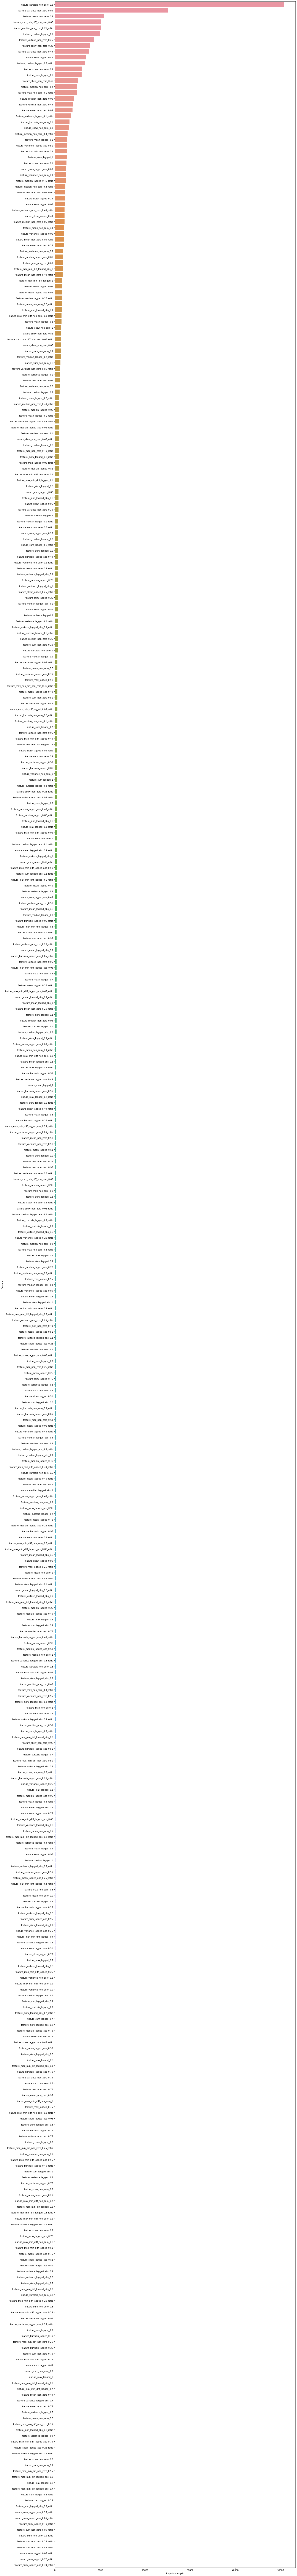

In [21]:
lgbm_model.plot_importance([model], preds)

#### Feature selection

After few repetitions of trying of run with different subset of features, first 25 most importan features of the model with all features was selected.

Note: Of course, it would be possible, to provide a bit more sophisticated feature selection process, at least as droping the features one by one and checking validation performance. But to keep this notebook still readable with not skipping any single step in model development, then keep this procedure a bit simpler with only removing those last four features, while keeping the rest as selected to the final model.

In [29]:
x = lgbm_model.comp_var_imp([model], preds=preds)

In [70]:
new_features = x.sort_values(by = 'Importance_gain', ascending = False)['Feature'].head(25).tolist()

In [76]:
lgbm_model = LGBMModel(config)
model, valid_data, valid_target = lgbm_model.fit(train_data[new_features], train_target)

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1050]	valid_0's auc: 0.928865


Performance with leaner model almost did not change.

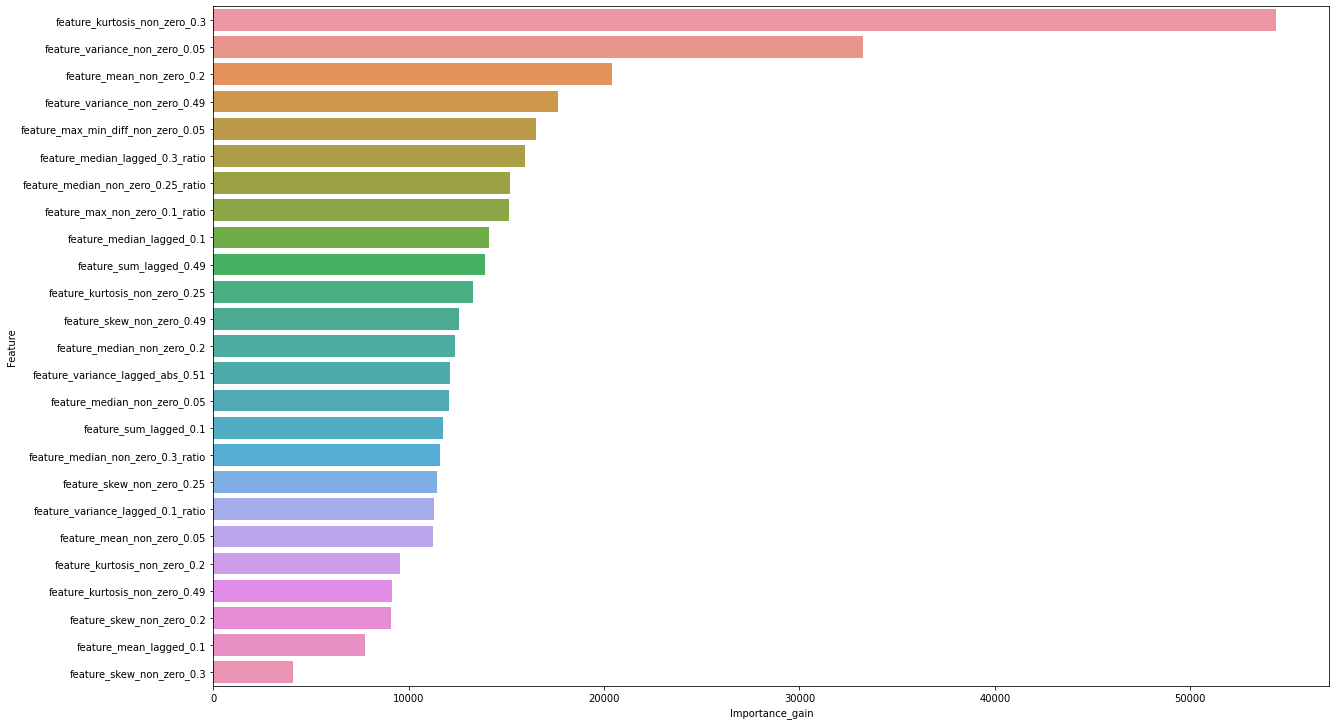

In [79]:
lgbm_model.plot_importance([model], new_features)

## Valid data evaluation

Moreover to the evaluation of the algorithm through its sorting power (auc metric), maybe we would like to predict actual label category- whether Pump failed or Not. This is a bit more tricky task, then only prediction of the probabilities of the model, because there needs to be set a threshold, based on which can be decided whether Pump failed or not. 

Because it is not fully know from the use case whether our aim is to maximize recall or precision (depends how much we care about having lot of false positive cases), we will try to set the threshold based on validation data that will optimize so-call F1 score - metric between 0-1, that takes into account balance between precision and recall.

In [ ]:
valid_metrics = Metrics(valid_target, lgbm_model.predict(valid_data, model))
valid_metrics.calculate_stats()

Plot F1-score as a function of threshold for validation data

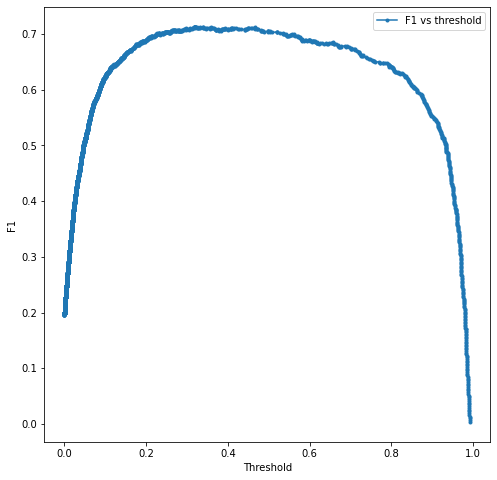

In [81]:
valid_metrics.plot_F1_vs_threshold()

In [82]:
print(f'Optimal threshold is {valid_metrics.threshold}')
threshold_to_use = valid_metrics.threshold

Optimal threshold is 0.3204474158637227


In [83]:
valid_metrics.calculate_label_predictions()
valid_metrics.print_all_metrics()

Area under ROC curve:
0.9288649212218546
F1 score:
0.7123050259965338
Precision
0.7611111111111111
Recall:
0.6693811074918566
Confusion Matrix:
[[4901  129]
 [ 203  411]]


## Test data evaluation

Evaluating completely unseen testing data. The threshold for label classification is selected the one from the validation data. 

In [84]:
test_metrics = Metrics(test_target, lgbm_model.predict(test_data[new_features], model), threshold = threshold_to_use)

In [85]:
test_metrics.calculate_label_predictions()
test_metrics.print_all_metrics()

Area under ROC curve:
0.9266959681310172
F1 score:
0.7045033929673042
Precision
0.7532981530343008
Recall:
0.6616454229432214
Confusion Matrix:
[[6975  187]
 [ 292  571]]


We can see that all the metrics are for the test set similar as for the validation set, which is good sign that the model shouldn't be overfitted. Both metrics, AUC score and F1 score are indicating good classification power of the algorithm. 

# False negative cases

Lets have a look at 4 cases with lowest prediction score that are actually positive (real target = 1)

In [179]:
test_data['prediction'] = lgbm_model.predict(test_data[new_features], model)
test_data[test_data['PumpFailed']==1].sort_values(by = 'prediction')[['MachineId','MeasurementId', 'prediction']].head(4)

,MachineId,MeasurementId,prediction
1174,10_0_1,1722,0.000431
1989,4_3_0,2773,0.001348
686,1_0_2,1006,0.001441
1343,4_2_3,1984,0.002346


machine_id: 10_0_1, measurement_id:1722
No observatons:
(399,)
     MachineId  MeasurementId PumpFailed SlowStart SlowEnd    random
3965    10_0_1           1722       True     False   False  0.787372


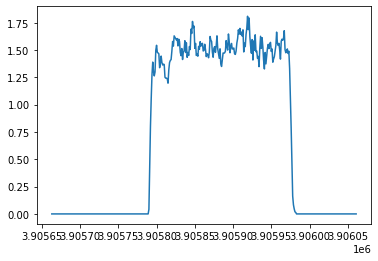

In [172]:
show_series(data, labels, '10_0_1', 1722)

machine_id: 4_3_0, measurement_id:2773
No observatons:
(329,)
     MachineId  MeasurementId PumpFailed SlowStart SlowEnd    random
6771     4_3_0           2773       True     False   False  0.870025


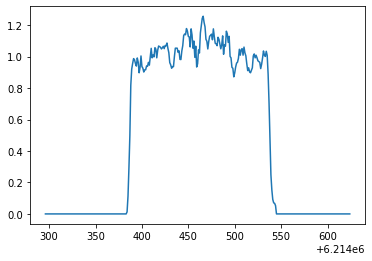

In [177]:
show_series(data, labels, '4_3_0', 2773)

machine_id: 1_0_2, measurement_id:1006
No observatons:
(1171,)
     MachineId  MeasurementId PumpFailed SlowStart SlowEnd    random
2311     1_0_2           1006       True     False   False  0.874223


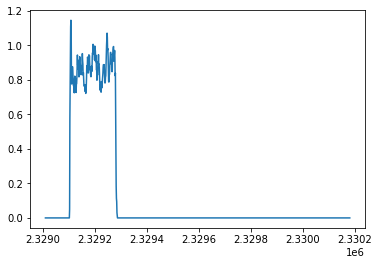

In [178]:
show_series(data, labels, '1_0_2', 1006)

machine_id: 4_2_3, measurement_id:1984
No observatons:
(657,)
     MachineId  MeasurementId PumpFailed SlowStart SlowEnd    random
4619     4_2_3           1984       True     False   False  0.858698


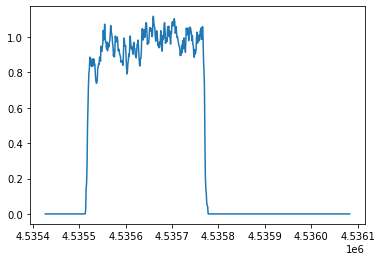

In [180]:
show_series(data, labels, '4_2_3', 1984)

Looks like pattern of Pumpfail on those series is poorely visible, but maybe some additional features can be figured out based on these images - for example statistics based on the sliding window.

## Explanation of the model - SHAP values

Importance of the features based on SHAP values
Shap values is superpowerful method that gives us contribution to the predicted outcome of each variable for every single observation. Therefore it brings local interpretability to every prediction and makes this model less 'black-box'.

Variables are sorted according their mean absolute impact on the prediction. And the SHAP value on x-axis means difference contribution to the prediction - average prediction in logits.

SHAP dependence plot shows real relation between variable and prediction and with this tool one can check that the variable in the model behaves similarly as is expected for example from EDA.

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


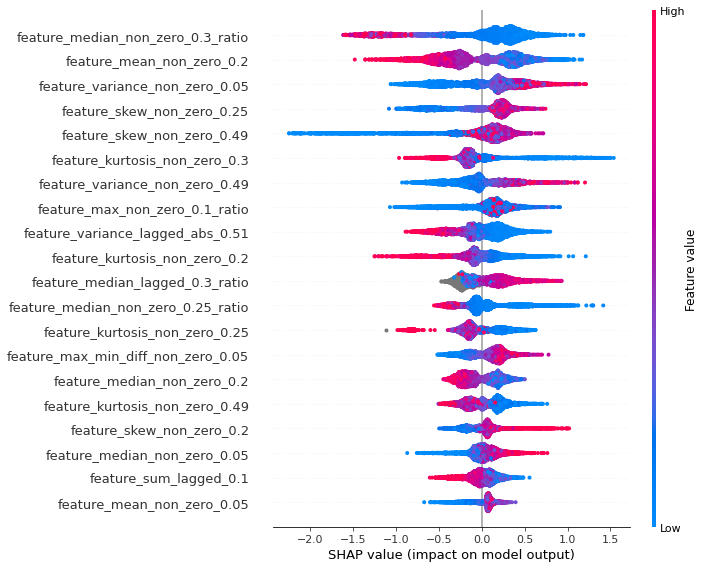

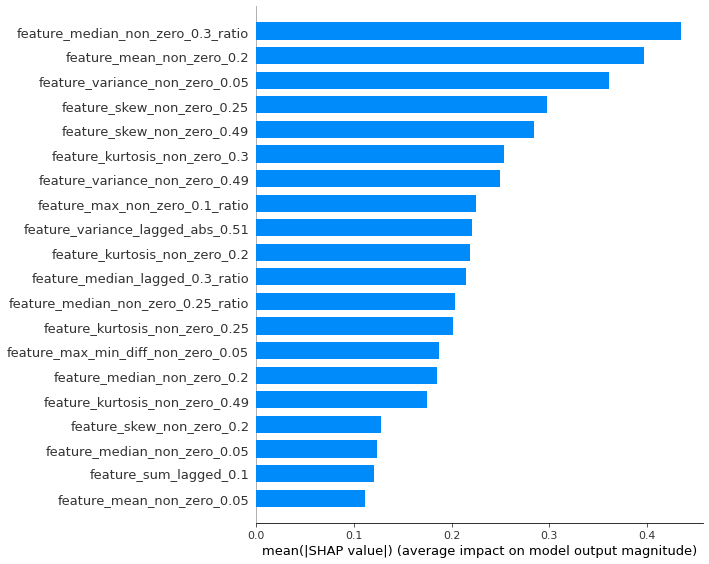

In [86]:
lgbm_model.print_shap_values(model, valid_data)